In [40]:
import pandas as pd; import numpy as np; import matplotlib.pyplot as plt;

from statsmodels.tsa.arima.model import ARIMA;
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.graphics.tsaplots import plot_acf;
from statsmodels.graphics.tsaplots import plot_pacf;
from statsmodels.api import OLS, add_constant
from statsmodels.tools.sm_exceptions import MissingDataError

from scipy.interpolate import CubicSpline
from scipy.stats import t,f

import warnings as yapping; yapping.simplefilter('ignore')

import os
data_dir = './data'

In [41]:
data = pd.read_excel(os.path.join(data_dir, 'advert.xlsx'),header=0)
data

,x,y
0,4,27.0
1,3,25.7
2,0,24.3
3,5,23.2
4,3,27.6
...,...,...
115,1,25.3
116,8,22.5
117,8,25.7
118,0,29.3


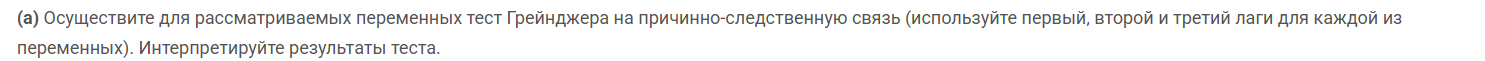

In [42]:
def adf_stationary_test(series, signif=0.05):
    result = adfuller(series, autolag='AIC')
    p_value = result[1]
    return (p_value < signif)


print(f'Ряд x {'' if adf_stationary_test(data.x) else 'не'}стационарен')
print(f'Ряд y {'' if adf_stationary_test(data.y) else 'не'}стационарен')

Ряд x стационарен
Ряд y стационарен


In [68]:
def granger_causality(X: pd.Series, Y: pd.Series, max_lag: int,verbose:bool = False) -> dict:
    """
    Выполняет тест Грейнджера на причинно-следственную связь.
    
    Аргументы:
        X (pd.Series): Первый временной ряд.
        Y (pd.Series): Второй временной ряд.
        max_lag (int): Максимальное количество лагов для проверки.
        verbose (bool,optional): Осуществить вывод результатов
    
    Возвращает:
        dict: Для каждого лага возвращает F-статистику и p-значение.
    """
    if len(X) != len(Y):
        raise ValueError("Длины временных рядов должны совпадать")
    
    results = {}
    
    for lag in range(1, max_lag + 1):
        # Создаем лаги для X и Y
        X_lags = pd.concat([X.shift(i) for i in range(1, lag+1)], axis=1)
        Y_lags = pd.concat([Y.shift(i) for i in range(1, lag+1)], axis=1)
        
        # Выравниваем индексы и удаляем пропуски
        common_idx = X_lags.dropna().index.intersection(Y_lags.dropna().index).intersection(Y.index)
        X_lags = X_lags.loc[common_idx].values
        Y_lags = Y_lags.loc[common_idx].values
        Y_current = Y.loc[common_idx].values
        
        # Матрицы регрессоров
        X_unrestricted = np.column_stack((np.ones(len(X_lags)), X_lags, Y_lags))
        X_restricted = np.column_stack((np.ones(len(Y_lags)), Y_lags))
        
        # Рассчитываем коэффициенты и RSS
        coeffs_unr, _, _, _ = np.linalg.lstsq(X_unrestricted, Y_current, rcond=None)
        rss_unr = ((Y_current - X_unrestricted @ coeffs_unr)**2).sum()
        
        coeffs_res, _, _, _ = np.linalg.lstsq(X_restricted, Y_current, rcond=None)
        rss_res = ((Y_current - X_restricted @ coeffs_res)**2).sum()
        
        # F-статистика
        n = len(Y_current)
        k_unr = X_unrestricted.shape[1]
        k_res = X_restricted.shape[1]
        q = k_unr - k_res
        
        f_stat = ((rss_res - rss_unr)/q) / (rss_unr/(n - k_unr))
        p_val = 1 - f.cdf(f_stat, q, n - k_unr)
        
        results[lag] = {'f_statistic': f_stat, 'p_value': p_val}
        
    if verbose:
        tab = 6+len(str(max_lag))
        for lag, res in results.items():
            print(f"{f"Лаг {lag}":^{tab}}: Причинность X → Y {'' if res['p_value']<0.05 else 'не'} подтверждается\n{' '*(tab+2)}F={res['f_statistic']:.3f}\n{' '*(tab+2)}p={res['p_value']:.3f}\n")
    return results

max_lag = 3
results = granger_causality(data.x, data.y,max_lag, True)

 Лаг 1 : Причинность X → Y  подтверждается
         F=518.530
         p=0.000

 Лаг 2 : Причинность X → Y  подтверждается
         F=253.251
         p=0.000

 Лаг 3 : Причинность X → Y  подтверждается
         F=166.970
         p=0.000



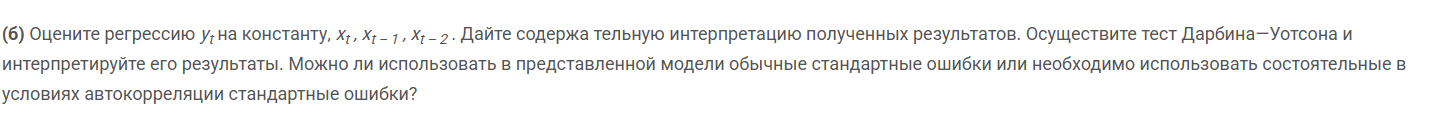

In [70]:
xt = data.x
yt = data.y

# 1. Создание регрессоров с лагами
X = pd.DataFrame({
    'const': 1,
    'xt': xt,
    'xt_1': xt.shift(1),
    'xt_2': xt.shift(2)
}).dropna()  # Удаляем пропуски из-за лагов

y = yt.loc[X.index]  # Выравниваем с усеченной выборкой

# 2. Оценка коэффициентов МНК
X_mat = X.values
y_mat = y.values

# МНК через нормальное уравнение
XTX = X_mat.T @ X_mat
XTy = X_mat.T @ y_mat
beta = np.linalg.inv(XTX) @ XTy

# 3. Остатки
y_hat = X_mat @ beta
residuals = y_mat - y_hat

# 4. Тест Дарбина-Уотсона
numerator = np.sum(np.diff(residuals, n=1)**2)
denominator = np.sum(residuals**2)
dw_statistic = numerator / denominator

# 5. Стандартные ошибки МНК (для сравнения)
rss = np.sum(residuals**2)
sigma2 = rss / (len(y) - X_mat.shape[1])
vcov = sigma2 * np.linalg.inv(XTX)
std_errors = np.sqrt(np.diag(vcov))

# Результаты
results = pd.DataFrame({
    'Coefficient': beta,
    'Std. Error (OLS)': std_errors
}, index=X.columns)

print("Результаты регрессии:")
print(results)
print(f"\nТест Дарбина-Уотсона: {dw_statistic:.3f}")

# Интерпретация
if dw_statistic < 1.5:
    print("Признаки положительной автокорреляции остатков.")
elif dw_statistic > 2.5:
    print("Признаки отрицательной автокорреляции остатков.")
else:
    print("Автокорреляция остатков не обнаружена.")

Результаты регрессии:
       Coefficient  Std. Error (OLS)
const    21.688917          0.387365
xt       -0.010962          0.046190
xt_1      0.830543          0.046551
xt_2      0.414882          0.046981

Тест Дарбина-Уотсона: 1.117
Признаки положительной автокорреляции остатков.


In [72]:
xt = data.x
yt = data.y

# 1. Создание регрессоров с лагами
X = pd.DataFrame({
    'xt': xt,
    'xt_1': xt.shift(1),
    'xt_2': xt.shift(2)
}).dropna()  # Удаляем пропуски из-за лагов

y = yt.loc[X.index]  # Выравниваем с усеченной выборкой

# 2. Оценка коэффициентов МНК
X_mat = X.values
y_mat = y.values

# МНК через нормальное уравнение
XTX = X_mat.T @ X_mat
XTy = X_mat.T @ y_mat
beta = np.linalg.inv(XTX) @ XTy

# 3. Остатки
y_hat = X_mat @ beta
residuals = y_mat - y_hat

# 4. Тест Дарбина-Уотсона
numerator = np.sum(np.diff(residuals, n=1)**2)
denominator = np.sum(residuals**2)
dw_statistic = numerator / denominator

# 5. Стандартные ошибки МНК (для сравнения)
rss = np.sum(residuals**2)
sigma2 = rss / (len(y) - X_mat.shape[1])
vcov = sigma2 * np.linalg.inv(XTX)
std_errors = np.sqrt(np.diag(vcov))

# Результаты
results = pd.DataFrame({
    'Coefficient': beta,
    'Std. Error (OLS)': std_errors
}, index=X.columns)

print("Результаты регрессии:")
print(results)
print(f"\nТест Дарбина-Уотсона: {dw_statistic:.3f}")

# Интерпретация
if dw_statistic < 1.5:
    print("Признаки положительной автокорреляции остатков.")
elif dw_statistic > 2.5:
    print("Признаки отрицательной автокорреляции остатков.")
else:
    print("Автокорреляция остатков не обнаружена.")

Результаты регрессии:
      Coefficient  Std. Error (OLS)
xt       1.348326          0.208865
xt_1     2.438015          0.194771
xt_2     1.789354          0.212917

Тест Дарбина-Уотсона: 0.600
Признаки положительной автокорреляции остатков.


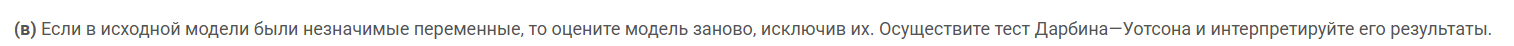

In [73]:
# Удаляем незначимый xt (на основе предыдущих результатов)
X_reduced = pd.DataFrame({
    'const': 1,
    'xt_1': xt.shift(1),
    'xt_2': xt.shift(2)
}).dropna()

y_reduced = yt[X_reduced.index]

# Оценка МНК
X_mat = X_reduced.values
y_mat = y_reduced.values

XTX = X_mat.T @ X_mat
XTy = X_mat.T @ y_mat
beta = np.linalg.inv(XTX) @ XTy

# Остатки
y_hat = X_mat @ beta
residuals = y_mat - y_hat

# Тест Дарбина-Уотсона
dw_statistic = np.sum(np.diff(residuals)**2) / np.sum(residuals**2)

# Стандартные ошибки
rss = np.sum(residuals**2)
sigma2 = rss / (len(y_mat) - X_mat.shape[1])
vcov = sigma2 * np.linalg.inv(XTX)
std_errors = np.sqrt(np.diag(vcov))

results = pd.DataFrame({
    'Coefficient': beta,
    'Std. Error (OLS)': std_errors
}, index=X_reduced.columns)

print("Результаты усеченной регрессии:")
print(results)
print(f"\nТест Дарбина-Уотсона: {dw_statistic:.3f}")

if dw_statistic < 1.5:
    print("Обнаружена положительная автокорреляция остатков. Рекомендуется использовать робастные стандартные ошибки.")
elif dw_statistic > 2.5:
    print("Обнаружена отрицательная автокорреляция остатков.")
else:
    print("Автокорреляция остатков отсутствует.")

Результаты усеченной регрессии:
       Coefficient  Std. Error (OLS)
const    21.640600          0.328191
xt_1      0.831631          0.046134
xt_2      0.413805          0.046569

Тест Дарбина-Уотсона: 1.113
Обнаружена положительная автокорреляция остатков. Рекомендуется использовать робастные стандартные ошибки.
